In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.api import Holt, ExponentialSmoothing


from acquire import wrangle_store_data
from prepare import index_time_data, prep_store_data

In [2]:
df = wrangle_store_data()

In [3]:
df['sale_total'] = df.sale_amount * df.item_price

In [4]:
df = prep_store_data(df)

In [5]:
df.head()

,store_id,item_id,item_upc14,item_upc12,item_brand,item_name,item_price,sale_id,quantity,store_address,store_zipcode,store_city,store_state,sale_total,month,dow,sales_total
sale_date,,,,,,,,,,,,,,,,,
2013-01-01,1,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,1,13,12125 Alamo Ranch Pkwy,78253,San Antonio,TX,10.92,01-Jan,2-Tue,10.92
2013-01-01,3,17,88313590791,88313590791,Ducal,Ducal Refried Red Beans,1.16,295813,26,2118 Fredericksburg Rdj,78201,San Antonio,TX,30.16,01-Jan,2-Tue,30.16
2013-01-01,10,7,70177154004,70177154004,Twinings Of London,Twinings Of London Classics Lady Grey Tea - 20 Ct,9.64,125995,32,8503 NW Military Hwy,78231,San Antonio,TX,308.48,01-Jan,2-Tue,308.48
2013-01-01,3,18,21200725340,21200725340,Scotch,Scotch Removable Clear Mounting Squares - 35 Ct,4.39,314073,45,2118 Fredericksburg Rdj,78201,San Antonio,TX,197.55,01-Jan,2-Tue,197.55
2013-01-01,3,19,41520035646,41520035646,Careone,Careone Family Comb Set - 8 Ct,0.74,332333,34,2118 Fredericksburg Rdj,78201,San Antonio,TX,25.16,01-Jan,2-Tue,25.16


In [6]:
df_resampled = df.resample('M', convention='end')[['quantity','sales_total']].sum()
df_resampled.head()

,quantity,sales_total
sale_date,,
2013-01-31,454904,2447368.20
2013-02-28,459417,2469765.97
2013-03-31,617382,3319815.58
2013-04-30,682274,3666901.23
2013-05-31,763242,4102278.40


In [7]:
# set train size to be 50% of total 
train_size = int(round(df_resampled.shape[0] * 0.5))
train_size

# set validate size to be 30% of total 
validate_size = int(round(df_resampled.shape[0] * 0.3))
validate_size

# set test size to be number of rows remaining. 
test_size = int(round(df_resampled.shape[0] * 0.2))
test_size

12

In [8]:
# validate
validate_end_index = train_size + validate_size
validate_end_index

48

In [9]:
# train
train = df_resampled[:train_size]

In [10]:
# validate
validate = df_resampled[train_size:validate_end_index]

In [11]:
# test
test = df_resampled[validate_end_index:]

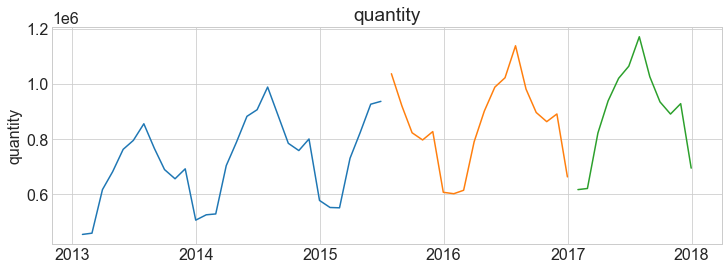

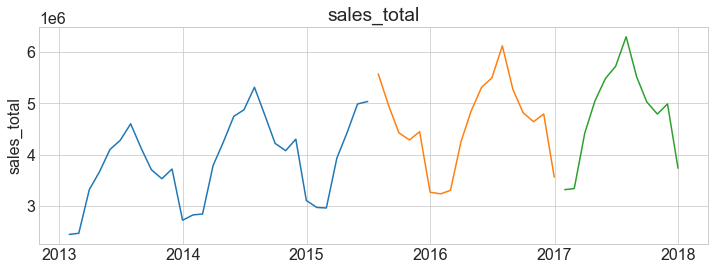

In [12]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()


In [13]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [14]:
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [15]:
# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [16]:
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [17]:
train['sales_total'][-1:][0]

5037761.76

# last value

In [18]:
# take the last item of sales total and assign to variable
last_sales = train['sales_total'][-1:][0]
last_sales

5037761.76

In [19]:
# take the last item of quantity and assign to variable
last_quantity = train['quantity'][-1:][0]
last_quantity

937184

In [20]:
yhat_df = pd.DataFrame(
    {'sales_total': [last_sales],
     'quantity': [last_quantity]},
    index=validate.index)

yhat_df.head()

,sales_total,quantity
sale_date,,
2015-07-31,5037761.76,937184
2015-08-31,5037761.76,937184
2015-09-30,5037761.76,937184
2015-10-31,5037761.76,937184
2015-11-30,5037761.76,937184


sales_total -- RMSE: 929649


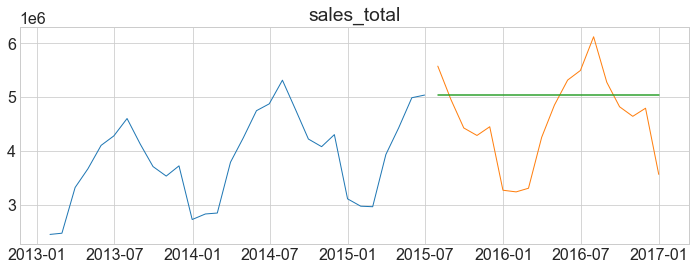

In [21]:
plot_and_eval('sales_total')

quantity -- RMSE: 172989


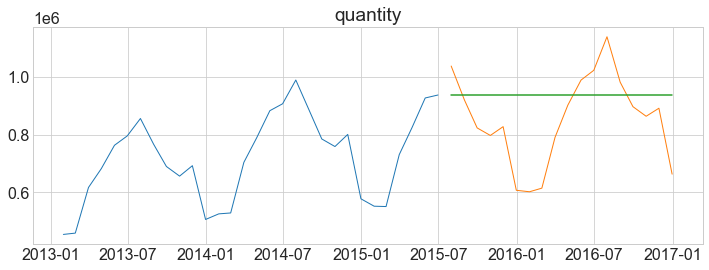

sales_total -- RMSE: 929649


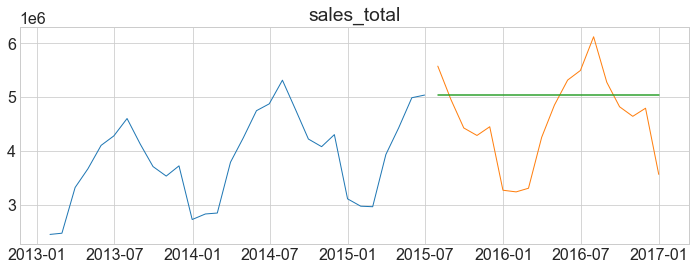

In [22]:
for col in train.columns:
    plot_and_eval(col)

In [23]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,quantity,172989.0
1,last_observed_value,sales_total,929649.0


# simple average

In [24]:
# compute simple average
avg_sales = round(train['sales_total'].mean(), 2)
avg_sales

3871057.0

In [25]:
avg_quantity = round(train['quantity'].mean(), 2)
avg_quantity

720001.97

In [26]:
def make_predictions(sales=None, quantity=None):
    yhat_df = pd.DataFrame({'sales_total': [sales],
                           'quantity': [quantity]},
                          index=validate.index)
    return yhat_df

In [27]:
yhat_df = make_predictions(avg_sales, avg_quantity)

quantity -- RMSE: 202312


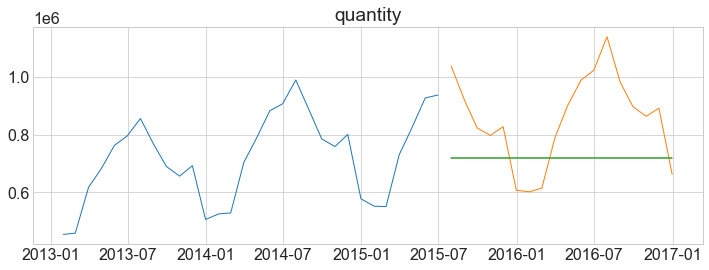

sales_total -- RMSE: 1087281


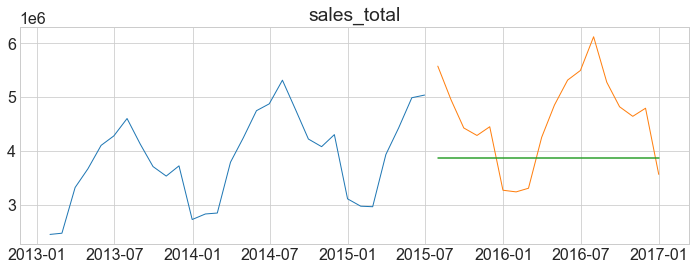

In [28]:
for col in train.columns:
    plot_and_eval(col)

In [29]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                            target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,quantity,172989.0
1,last_observed_value,sales_total,929649.0
2,simple_average,quantity,202312.0
3,simple_average,sales_total,1087281.0


# moving average/

In [30]:
period=1
train['sales_total'].rolling(period).mean()[-1]

5037761.76

In [31]:
rolling_sales = round(train['sales_total'].rolling(period).mean()[-1], 2)
rolling_quantity = round(train['quantity'].rolling(period).mean()[-1], 2)
print(rolling_sales, rolling_quantity)

5037761.76 937184.0


In [32]:
yhat_df = make_predictions(rolling_sales, rolling_quantity)
yhat_df.head()

,sales_total,quantity
sale_date,,
2015-07-31,5037761.76,937184.0
2015-08-31,5037761.76,937184.0
2015-09-30,5037761.76,937184.0
2015-10-31,5037761.76,937184.0
2015-11-30,5037761.76,937184.0


quantity -- RMSE: 172989


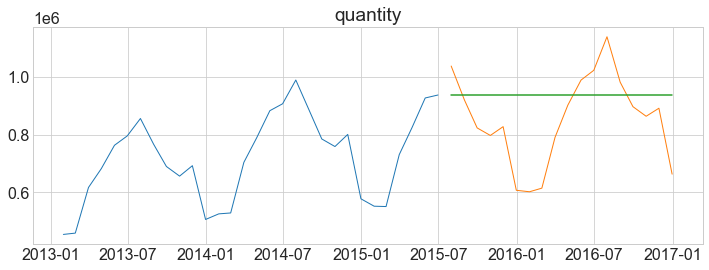

sales_total -- RMSE: 929649


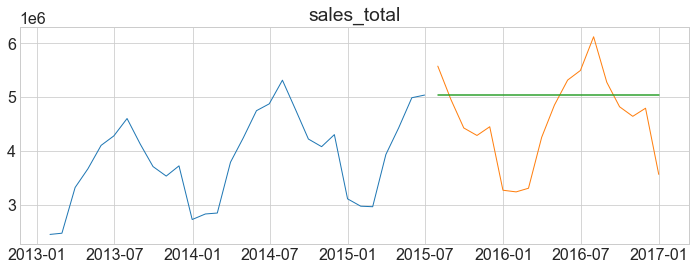

In [33]:
for col in train.columns:
    plot_and_eval(col)

In [34]:
for col in train.columns:
    eval_df = append_eval_df(model_type = '30d_moving_avg', 
                            target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,quantity,172989.0
1,last_observed_value,sales_total,929649.0
2,simple_average,quantity,202312.0
3,simple_average,sales_total,1087281.0
4,30d_moving_avg,quantity,172989.0
5,30d_moving_avg,sales_total,929649.0


In [35]:
min_items_rmse = eval_df[eval_df.target_var == 'quantity']['rmse'].min()

In [36]:
min_items_rmse

172989.0

In [37]:
import statsmodels.api as sm

sales_total 



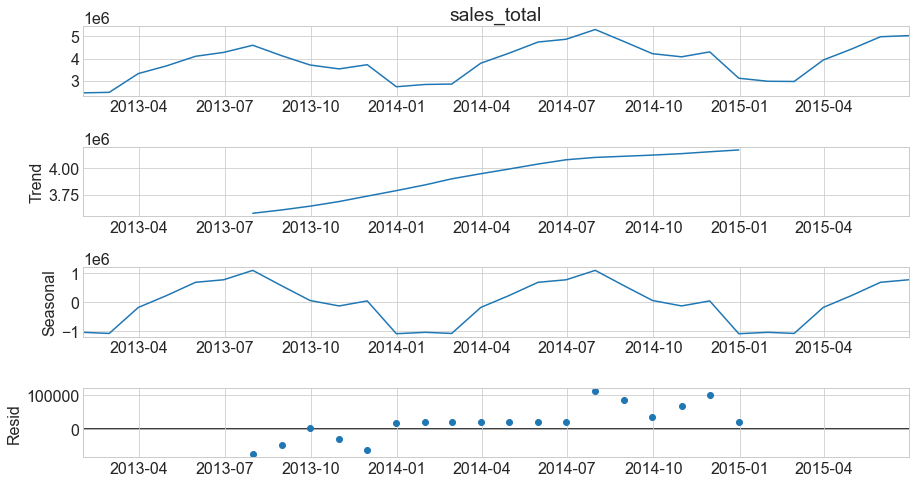

In [38]:
print(col, '\n')
sm.tsa.seasonal_decompose(train[col].resample('M').mean()).plot()
plt.show()

quantity 

sales_total 



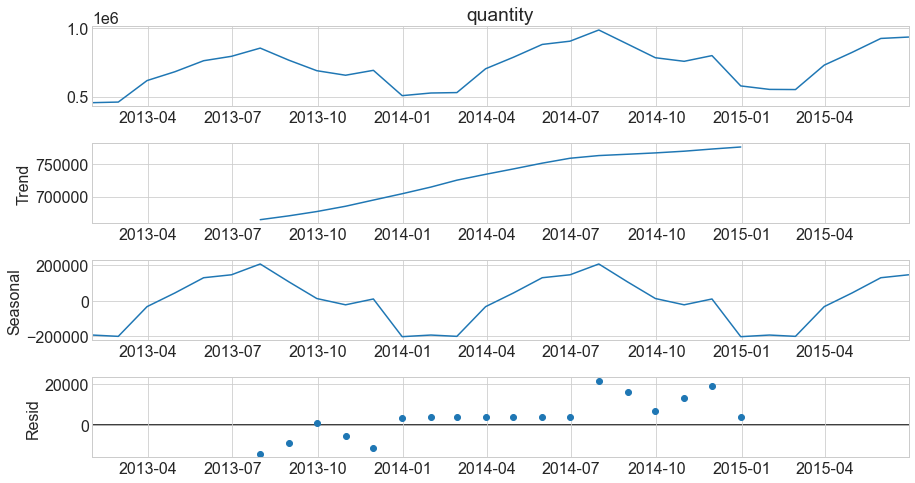

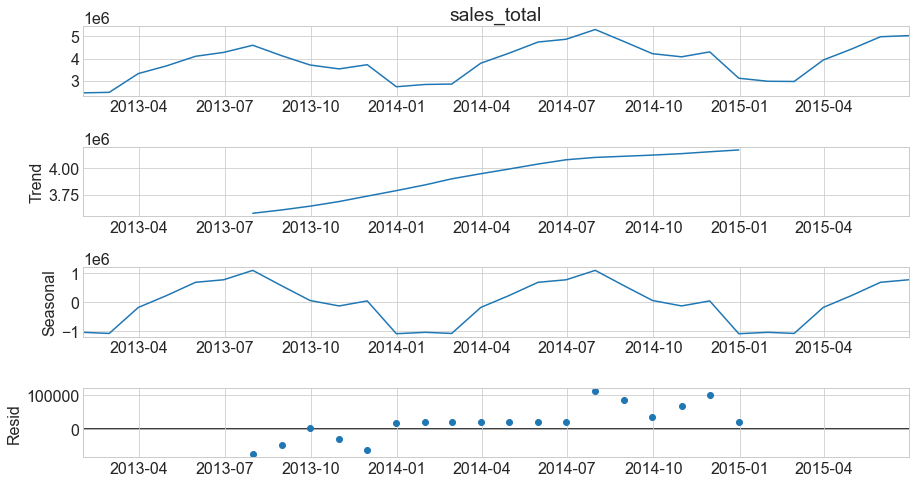

In [39]:
for col in train.columns:
    print(col,'\n')
    sm.tsa.seasonal_decompose(train[col].resample('M').mean()).plot()

### Basic Holt

In [40]:
train.columns

Index(['quantity', 'sales_total'], dtype='object')

In [41]:
col = 'sales_total' 
# create our Holt's Object
model = Holt(train[col], exponential=False, damped=True)

In [42]:
# fit the holt's object
model = model.fit(optimized=True)

In [43]:
yhat_items = model.predict(start = validate.index[0],
                              end = validate.index[-1])

In [44]:
validate.shape

(18, 2)

In [45]:
# doing this in a loop for each column
for col in train.columns:
    model = Holt(train[col], exponential=False, damped=True)
    model = model.fit(optimized=True)
    yhat_items = model.predict(start = validate.index[0],
                              end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

In [46]:
col = 'sales_total'
# create the Holt object 
model = Holt(train[col], exponential=False, damped=True)
# fit the model 
model = model.fit(optimized=True)
# make predictions for each date in validate 
yhat_items = model.predict(start = validate.index[0],
                           end = validate.index[-1])
# add predictions to yhat_df
yhat_df[col] = round(yhat_items, 2)

quantity -- RMSE: 188450


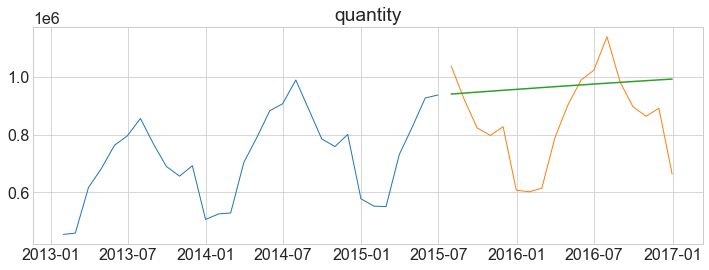

sales_total -- RMSE: 1005557


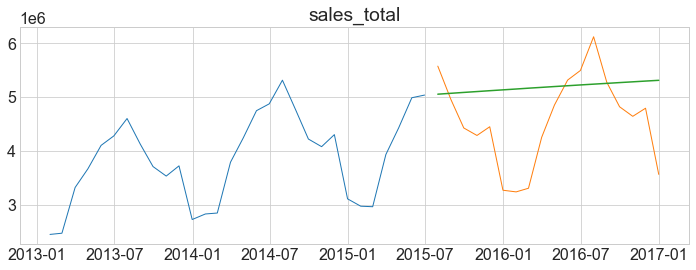

In [47]:
for col in train.columns:
    plot_and_eval(target_var = col)

In [48]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_optimized', 
                            target_var = col)

In [49]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
0,last_observed_value,quantity,172989.0
4,30d_moving_avg,quantity,172989.0
6,holts_optimized,quantity,188450.0
2,simple_average,quantity,202312.0
1,last_observed_value,sales_total,929649.0
5,30d_moving_avg,sales_total,929649.0
7,holts_optimized,sales_total,1005557.0
3,simple_average,sales_total,1087281.0


### Holt's Seasonal Trend

In [53]:
# Models for quantity
fit1 = ExponentialSmoothing(train.quantity, seasonal_periods=12, trend='add', seasonal='add').fit() #.fit(use_boxcox=True)
fit2 = ExponentialSmoothing(train.quantity, seasonal_periods=12, trend='add', seasonal='mul').fit() #.fit(use_boxcox=True)
fit3 = ExponentialSmoothing(train.quantity, seasonal_periods=12, trend='add', seasonal='add', damped=True).fit() #.fit(use_boxcox=True)
fit4 = ExponentialSmoothing(train.quantity, seasonal_periods=12, trend='add', seasonal='mul', damped=True).fit() #.fit(use_boxcox=True)

# Models for sales
fit5 = ExponentialSmoothing(train.sales_total, seasonal_periods=12, trend='add', seasonal='add').fit()#.fit(use_boxcox=True)
fit6 = ExponentialSmoothing(train.sales_total, seasonal_periods=12, trend='add', seasonal='mul').fit()#.fit(use_boxcox=True)
fit7 = ExponentialSmoothing(train.sales_total, seasonal_periods=12, trend='add', seasonal='add', damped=True).fit()#.fit(use_boxcox=True)
fit8 = ExponentialSmoothing(train.sales_total, seasonal_periods=12, trend='add', seasonal='mul', damped=True).fit()#.fit(use_boxcox=True)

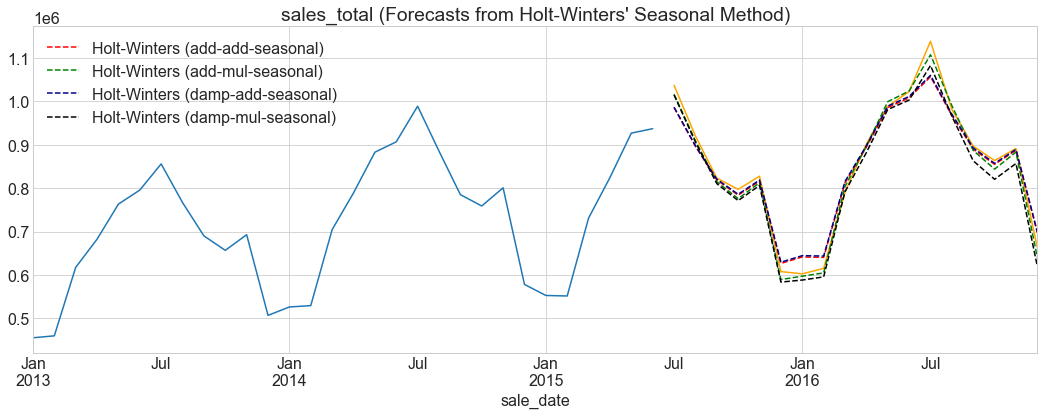

In [54]:
results_quantity=pd.DataFrame(index=[r"$\alpha$",r"$\beta$",r"$\phi$",r"$\gamma$",r"$l_0$","$b_0$","SSE"])
params = ['smoothing_level', 'smoothing_trend', 'damping_trend', 'smoothing_seasonal', 'initial_level', 'initial_trend']
results_quantity["Additive_Quantity"]       = [fit1.params[p] for p in params] + [fit1.sse]
results_quantity["Multiplicative_Quantity"] = [fit2.params[p] for p in params] + [fit2.sse]
results_quantity["Additive_Damp_Quantity"]   = [fit3.params[p] for p in params] + [fit3.sse]
results_quantity["Multiplica_Damp_Quantity"] = [fit4.params[p] for p in params] + [fit4.sse]

results_sales=pd.DataFrame(index=[r"$\alpha$",r"$\beta$",r"$\phi$",r"$\gamma$",r"$l_0$","$b_0$","SSE"])
params = ['smoothing_level', 'smoothing_trend', 'damping_trend', 'smoothing_seasonal', 'initial_level', 'initial_trend']
results_sales["Additive_Sales"]       = [fit5.params[p] for p in params] + [fit1.sse]
results_sales["Multiplicative_Sales"] = [fit6.params[p] for p in params] + [fit2.sse]
results_sales["Additive_Damp_Sales"]   = [fit7.params[p] for p in params] + [fit3.sse]
results_sales["Multiplica_Damp_Sales"] = [fit8.params[p] for p in params] + [fit4.sse]

ax = validate.quantity.plot(figsize=(18,6), color='orange', title="sales_total (Forecasts from Holt-Winters' Seasonal Method)")
ax.set_ylabel("")
ax.set_xlabel("Year")
train.quantity.plot()
#fit1.fittedvalues.plot(ax=ax, style='--', color='blue')
#fit2.fittedvalues.plot(ax=ax, style='--', color='orange')

fit1.forecast(validate.shape[0]).rename('Holt-Winters (add-add-seasonal)').plot(ax=ax, style='--', color='red', legend=True)
fit2.forecast(validate.shape[0]).rename('Holt-Winters (add-mul-seasonal)').plot(ax=ax, style='--', color='green', legend=True)
fit3.forecast(validate.shape[0]).rename('Holt-Winters (damp-add-seasonal)').plot(ax=ax, style='--', color='darkblue', legend=True)
fit4.forecast(validate.shape[0]).rename('Holt-Winters (damp-mul-seasonal)').plot(ax=ax, style='--', color='black', legend=True)

plt.show()

In [55]:
results_sales

,Additive_Sales,Multiplicative_Sales,Additive_Damp_Sales,Multiplica_Damp_Sales
$\alpha$,9.950000e-01,8.535714e-01,9.950000e-01,8.182143e-01
$\beta$,3.553571e-02,3.282967e-02,1.000000e-04,3.146978e-02
$\phi$,NaN,NaN,9.900000e-01,9.900000e-01
$\gamma$,5.000000e-03,1.464286e-01,5.000000e-03,1.817857e-01
$l_0$,3.505850e+06,3.505850e+06,3.505850e+06,3.505850e+06
$b_0$,4.803323e+04,4.803323e+04,4.803323e+04,4.803323e+04
SSE,6.879925e+09,3.937160e+09,6.722187e+09,3.871275e+09


In [56]:
results_quantity

,Additive_Quantity,Multiplicative_Quantity,Additive_Damp_Quantity,Multiplica_Damp_Quantity
$\alpha$,9.950000e-01,8.535714e-01,9.950000e-01,8.182143e-01
$\beta$,3.553571e-02,3.282967e-02,1.000000e-04,3.146978e-02
$\phi$,NaN,NaN,9.900000e-01,9.900000e-01
$\gamma$,5.000000e-03,1.464286e-01,5.000000e-03,1.817857e-01
$l_0$,6.520097e+05,6.520097e+05,6.520097e+05,6.520097e+05
$b_0$,8.938665e+03,8.938665e+03,8.938665e+03,8.938665e+03
SSE,6.879925e+09,3.937160e+09,6.722187e+09,3.871275e+09


In [57]:
yhat_df = fit8.forecast(validate.shape[0]).rename('sales_total').to_frame()
yhat_df['quantity'] = fit4.forecast(validate.shape[0]).rename('quantity').to_frame()
yhat_df

,sales_total,quantity
2015-07-31,5.455552e+06,1.014959e+06
2015-08-31,4.876000e+06,9.062411e+05
2015-09-30,4.356495e+06,8.104966e+05
2015-10-31,4.147427e+06,7.712392e+05
2015-11-30,4.331684e+06,8.062387e+05
2015-12-31,3.136550e+06,5.833889e+05
2016-01-31,3.161426e+06,5.881026e+05
2016-02-29,3.199775e+06,5.953565e+05
2016-03-31,4.259142e+06,7.916657e+05
2016-04-30,4.741366e+06,8.821076e+05


In [58]:
# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [59]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [61]:
evaluate('sales_total')

147099.0

In [62]:
evaluate('quantity')

27386.0

In [63]:
eval_df = append_eval_df('seasonal_holts_dampened_mult', 'sales_total')
eval_df = append_eval_df('seasonal_holts_dampened_mult', 'quantity')
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
9,seasonal_holts_dampened_mult,quantity,27386.0
8,seasonal_holts_dampened_mult,sales_total,147099.0
0,last_observed_value,quantity,172989.0
4,30d_moving_avg,quantity,172989.0
6,holts_optimized,quantity,188450.0
2,simple_average,quantity,202312.0
1,last_observed_value,sales_total,929649.0
5,30d_moving_avg,sales_total,929649.0
7,holts_optimized,sales_total,1005557.0
3,simple_average,sales_total,1087281.0


# Based on previous cycle..

In [64]:
train = df_resampled[:'2015']
validate = df_resampled['2016']
test = df_resampled['2017']

print(train.shape)
print(validate.shape)
print(test.shape)

train.head()
train.tail()

(36, 2)
(12, 2)
(12, 2)


,quantity,sales_total
sale_date,,
2015-08-31,920401,4951252.98
2015-09-30,823332,4426326.24
2015-10-31,797253,4286868.40
2015-11-30,827645,4448745.67
2015-12-31,607572,3268736.22


In [65]:
# finding the year-over-year difference for each day from 2013 to 2015
# taking the mean, and then adding that value to the daily 2015 values. 

# find yoy diff. from 2013-2014 and 2014-2015, take the mean, and add to each value in 2015. 
yhat_df = train['2015'] + train.diff(12).mean()

In [66]:
train.diff(12).mean()

quantity        66485.166667
sales_total    357433.869167
dtype: float64

In [67]:
train.loc['2015'].head()

,quantity,sales_total
sale_date,,
2015-01-31,552513,2971740.70
2015-02-28,551317,2962257.74
2015-03-31,730951,3932960.55
2015-04-30,824467,4427214.12
2015-05-31,926902,4988111.92


In [68]:
yhat_df.head()

,quantity,sales_total
sale_date,,
2015-01-31,618998.166667,3.329175e+06
2015-02-28,617802.166667,3.319692e+06
2015-03-31,797436.166667,4.290394e+06
2015-04-30,890952.166667,4.784648e+06
2015-05-31,993387.166667,5.345546e+06


In [69]:
pd.concat([yhat_df.head(1), validate.head(1)])

,quantity,sales_total
sale_date,,
2015-01-31,618998.166667,3.329175e+06
2016-01-31,602439.000000,3.237958e+06


In [70]:
yhat_df.index = validate.index

quantity -- RMSE: 13676


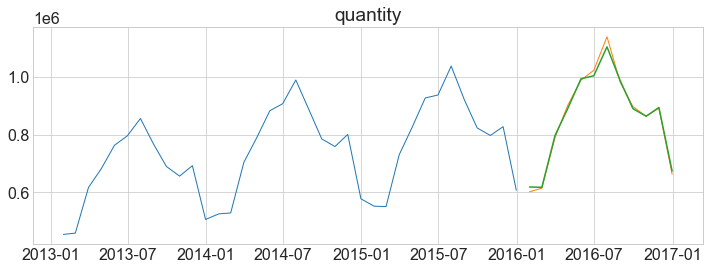

sales_total -- RMSE: 75034


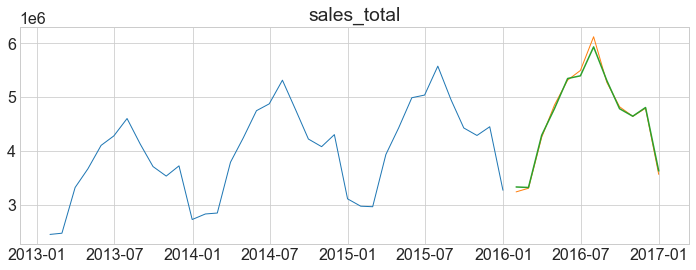

In [71]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = "previous_year", 
                            target_var = col)

In [72]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
10,previous_year,quantity,13676.0
9,seasonal_holts_dampened_mult,quantity,27386.0
11,previous_year,sales_total,75034.0
8,seasonal_holts_dampened_mult,sales_total,147099.0
0,last_observed_value,quantity,172989.0
4,30d_moving_avg,quantity,172989.0
6,holts_optimized,quantity,188450.0
2,simple_average,quantity,202312.0
1,last_observed_value,sales_total,929649.0
5,30d_moving_avg,sales_total,929649.0


In [73]:
sales_total_min_rmse = eval_df.groupby('target_var')['rmse'].min()[0]

quantity_min_rmse = eval_df.groupby('target_var')['rmse'].min()[1]

# find which model that is
eval_df[((eval_df.rmse == sales_total_min_rmse) | 
         (eval_df.rmse == quantity_min_rmse))]

,model_type,target_var,rmse
10,previous_year,quantity,13676.0
11,previous_year,sales_total,75034.0


In [74]:
yhat_df = validate + train.diff(12).mean()
yhat_df.index = test.index

In [75]:
yhat_df

,quantity,sales_total
sale_date,,
2017-01-31,6.689242e+05,3.595392e+06
2017-02-28,6.814422e+05,3.663108e+06
2017-03-31,8.573662e+05,4.610129e+06
2017-04-30,9.684352e+05,5.209362e+06
2017-05-31,1.055215e+06,5.673723e+06
2017-06-30,1.089149e+06,5.852177e+06
2017-07-31,1.205203e+06,6.479210e+06
2017-08-31,1.047979e+06,5.632322e+06
2017-09-30,9.633162e+05,5.177443e+06


In [76]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label='validate')
    plt.plot(test[target_var], label='test')
    plt.plot(yhat_df[target_var], alpha=.5)
    plt.title(target_var)
    plt.show()

In [77]:
rmse_sales_total = sqrt(mean_squared_error(test['sales_total'], 
                                       yhat_df['sales_total']))

rmse_quantity = sqrt(mean_squared_error(test['quantity'], 
                                       yhat_df['quantity']))

In [78]:
print('rmse-sales total: ', rmse_sales_total)
print('rmse-quantity: ', rmse_quantity)

rmse-sales total:  197043.7254737363
rmse-quantity:  36642.1370415567


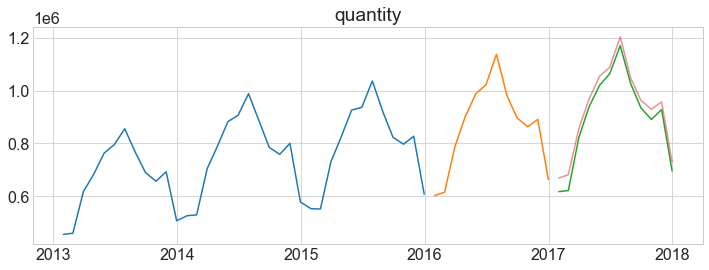

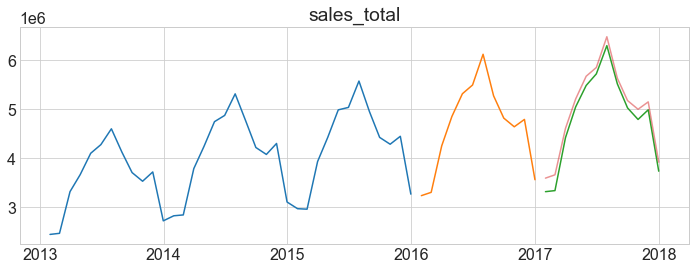

In [79]:
for col in train.columns:
    final_plot(col)

In [80]:
# to predict 2018

yhat_df = test + train.diff(12).mean()

yhat_df.index = test.index + pd.Timedelta('1Y')

In [81]:
yhat_df.head()

,quantity,sales_total
sale_date,,
2018-01-31 05:49:12,6.837912e+05,3.676734e+06
2018-02-28 05:49:12,6.878542e+05,3.698421e+06
2018-03-31 05:49:12,8.891522e+05,4.777891e+06
2018-04-30 05:49:12,1.005347e+06,5.405692e+06
2018-05-31 05:49:12,1.087171e+06,5.842629e+06


In [82]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label='validate')
    plt.plot(test[target_var], label='test')
    plt.plot(yhat_df[target_var], alpha=.5, label='forecast')
    plt.title(target_var)
    plt.legend()
    plt.show()

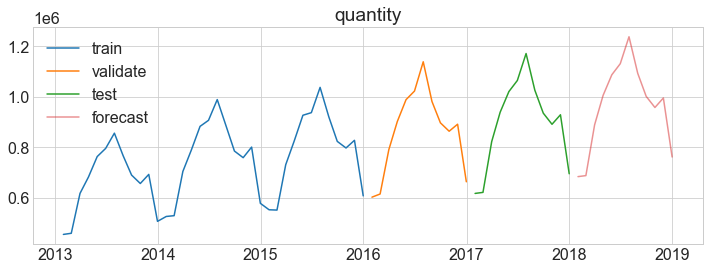

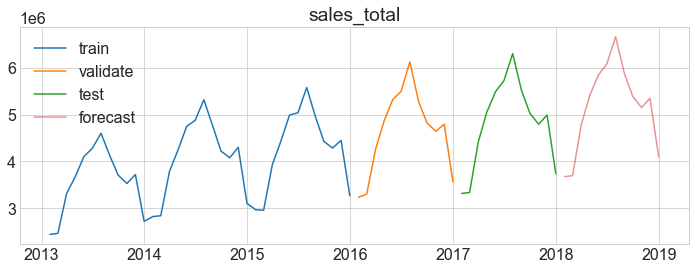

In [83]:
for col in train.columns:
    final_plot(col)